In [2]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops

from load_data import *
from models.customlayers import *
from models.activations import *
from training import *

import moviepy.editor as mpe
import models.ConvAE as cae
L = tf.layers

import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
data_dir = os.path.expanduser('~/Insight/video-representations/frames')
training_file = os.path.join(data_dir, 'training.tfrecords')
validation_file = os.path.join(data_dir, 'validation.tfrecords')
testing_file = os.path.join(data_dir, 'testing.tfrecords')

# Model

In [4]:
def invert_layer(input, invlayer_in, inv_layer_out):
    return tf.gradient(inv_layer_out, inv_layer_in, input)

def encoder(image):
    original_shape = image.get_shape().as_list()
    input_layer = tf.reshape(image, (-1, 60, 80, 3))
 
    conv1 = L.conv2d(
        input_layer, name='conv1',
        filters=16, kernel_size=3, activation=lrelu
    )
        
    conv2 = L.conv2d(
        conv1, name='conv2',
        filters=32, kernel_size=5, activation=lrelu
    )

    shape_ = conv2.get_shape().as_list()
    newdim = shape_[1] * shape_[2] * shape_[3]
    print(shape_, newdim)
    
    dense1 = dense_reshape(conv2, name='dense1', units=512, activation=lrelu)
    
    return tf.reshape(dense1, (-1, 64, 512))


def decoder(encoded):
    encoded_reshaped = tf.reshape(encoded, (-1, 512))
    
    dense1 = L.dense(encoded_reshaped, units=127872, activation=lrelu, name='dense1')

    dense1_reshaped = tf.reshape(dense1, (-1, 54, 74, 32))

    deconv3 = L.conv2d_transpose(
        dense1_reshaped, name='deconv3', 
        filters=32, kernel_size=5, activation=lrelu,
    )
    
    deconv4 = L.conv2d_transpose(
        deconv3, name='deconv4', 
        filters=3, kernel_size=3, activation=None,
    )
    
    deconv4_reshaped = tf.transpose(deconv4, perm=(0, 3, 1, 2))

    return deconv4_reshaped

lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=256)

def build_model(inputs, outputs, encoder, lstm_cell, decoder, batchsize):
    with tf.variable_scope('encoder'):
        encoded_input = encoder(inputs)
        encoded_input_reshaped = tf.reshape(encoded_input, (batchsize, -1, 512))
        
    with tf.variable_scope('encoder', reuse=True):
        encoded_output = encoder(outputs)
        encoded_output_reshaped = tf.reshape(encoded_output, (batchsize, -1, 512))
        
    with tf.variable_scope('lstm'):
        transitioned = tf.nn.dynamic_rnn(
            lstm_cell, encoded_input_reshaped, 
            sequence_length=[64]*batchsize, dtype=tf.float32, swap_memory=True
        )
        transitioned_reshaped = tf.reshape(transitioned[0], (-1, 256))
        encoded_prediction = L.dense(transitioned_reshaped, 512, activation=tf.nn.relu)
        encoded_prediction_reshaped = tf.reshape(encoded_prediction, (batchsize, -1, 512))
        
    with tf.variable_scope('decoder'):
        decoded = decoder(encoded_prediction)
        decoded_reshaped = tf.reshape(decoded, (batchsize, -1, 60, 80, 3))
        
    return encoded_output_reshaped, encoded_prediction_reshaped, decoded_reshaped

# note: relu output seems to give sharper lines

In [4]:
tf.reset_default_graph()

input_var = tf.placeholder(dtype=tf.float32, shape=(None, 3, 60, 80), name='input')
target_var = tf.placeholder(dtype=tf.float32, shape=(None, 3, 60, 80), name='target')

with tf.variable_scope('iencoder') as enc:
    encoded = encoder(input_var)
    
with tf.variable_scope('decoder') as dec:
    decoded = decoder(encoded)

[None, 54, 74, 32] 127872


In [5]:
def read_record(filepath_queue):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filepath_queue)
    
    features = tf.parse_single_example(
        serialized_example,
        features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            'video': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
            'length': tf.FixedLenFeature([], tf.int64)
        }
    )
    
    video = tf.decode_raw(features['video'], tf.uint8)   # feature may be renamed to video in future

    video_shape = tf.stack([-1, 60, 80, 3])
    video = tf.cast(tf.reshape(video, video_shape), tf.float32)
    video = tf.slice(video, [0, 0, 0, 0], [128, -1, -1, -1])
    video = (video - 127.5) / 127.5
    
    return video
    
def inputs(split_type, batchsize, num_epochs): 
    if not num_epochs:
        num_epochs = None
        
    filepath = os.path.join(data_dir, '{}.tfrecords'.format(split_type))
    
    with tf.name_scope('input'):
        filepath_queue = tf.train.string_input_producer([filepath], num_epochs=num_epochs)
    
    video = read_record(filepath_queue)
    videos = tf.train.shuffle_batch(
        [video], batchsize, 
        capacity=128 + 2*batchsize, min_after_dequeue=128, num_threads=2
    )
    
    video_inputs = tf.slice(videos, begin=[0, 0, 0, 0, 0], size=[-1, 64, -1, -1, -1])
    video_outputs = tf.slice(videos, begin=[0, 1, 0, 0, 0], size=[-1, 64, -1, -1, -1])
    
    return video_inputs, video_outputs

In [6]:
def run_training(num_epochs, batchsize):
    video_inputs, video_outputs = inputs('training', batchsize, num_epochs)
    
    targets, predictions, decoded = build_model(
        video_inputs, video_outputs, 
        encoder, lstm_cell, decoder, 
        batchsize
    )
        
    l2_weight = .01
    l2_vars = [v for v in tf.trainable_variables() if 'bias' not in v.name]
    l2_vars = [v for v in l2_vars if 'lstm' not in v.name]
    l2_term = tf.add_n([tf.nn.l2_loss(v) for v in l2_vars])
    
    loss = tf.reduce_mean(tf.pow(decoded - video_outputs, 2))
    train_step = tf.train.AdamOptimizer().minimize(loss + l2_weight*l2_term)
    
#     decoder_loss = tf.reduce_mean(tf.pow(decoded - video_outputs, 2))
#     decoder_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='decoder')
#     decoder_train_step = tf.train.AdamOptimizer().minimize(decoder_loss, var_list=decoder_vars)
    
    saver = tf.train.Saver()
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    
    coord = tf.train.Coordinator()
        
    with tf.Session() as sesh:
        sesh.run(init_global)
        sesh.run(init_local)
        threads = tf.train.start_queue_runners(sess=sesh, coord=coord)

        losses = []
        decoder_losses = []
            
        try:
            step = 0
            print(np.sum([np.prod(v.shape.as_list()) for v in tf.trainable_variables()]) / 1000000)

            while not coord.should_stop():
                _, loss_value = sesh.run([train_step, loss])
#                 _, decoder_loss_value = sesh.run([decoder_train_step, decoder_loss])
                losses.append(loss_value)
#                 decoder_losses.append(decoder_loss_value)
                if step % 500 == 0:
                    print('Step {} loss: {:.4f}'.format(step, loss_value))
#                     print('Step {} decoder loss: {:.4f}'.format(step, decoder_loss_value))

                step += 1

        except tf.errors.OutOfRangeError:
            print('Done; loss: {:.4f}'.format(loss_value))

        finally:
            coord.request_stop()

        coord.join(threads)
        
        saver.save(sesh, 'prototype-lstm')
    return losses, decoder_losses

In [6]:
losses = run_training(10, 4)

[256, 54, 74, 32] 127872
[256, 54, 74, 32] 127872
132.028131
Step 0 loss: 0.2349
Step 500 loss: 0.2951
Step 1000 loss: 0.2732
Step 1500 loss: 0.2971
Step 2000 loss: 0.3299
Step 2500 loss: 0.2013
Step 3000 loss: 0.2342
Step 3500 loss: 0.2449
Step 4000 loss: 0.2932
Step 4500 loss: 0.2911
Done; loss: 4997.0000


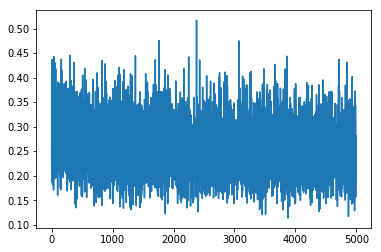

In [8]:
plt.plot(losses[0])

In [7]:
def run_inference(batchsize, num_epochs):
    video_inputs, video_outputs = inputs('training', batchsize, num_epochs)
    
    targets, predictions, decoded = build_model(
        video_inputs, video_outputs, 
        encoder, lstm_cell, decoder, 
        batchsize
    )

    saver = tf.train.Saver()
    
    loss = tf.reduce_mean(tf.pow(targets - predictions, 2))
    decoder_loss = tf.reduce_mean(tf.pow(decoded - video_inputs, 2))
    
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    
    coord = tf.train.Coordinator()
    
    with tf.Session() as sesh:
        sesh.run(init_global)
        sesh.run(init_local)
        saver.restore(sesh, 'prototype-lstm')
        threads = tf.train.start_queue_runners(sess=sesh, coord=coord)

        losses = []
        predictions = []
            
        try:
            step = 0

            while not coord.should_stop():
                prediction, loss_value = sesh.run([decoded, loss])
                losses.append(loss_value)

                if step % 100 == 0:
                    print('Step {} loss: {:.4f}'.format(step, loss_value))
                    predictions.append(prediction)

                step += 1

        except tf.errors.OutOfRangeError:
            print('Done; loss: {:.4f}'.format(loss_value))

        finally:
            coord.request_stop()

        coord.join(threads)
        
    return losses, predictions

In [7]:
losses, predictions = run_inference(4, 1)

[256, 54, 74, 32] 127872
[256, 54, 74, 32] 127872
INFO:tensorflow:Restoring parameters from prototype-lstm
Step 0 loss: 1.0216
Step 100 loss: 5.1698
Step 200 loss: 3.0293
Step 300 loss: 3.5475
Step 400 loss: 6.0285
Done; loss: 499.0000


In [8]:
predictions[0][0].shape

(64, 60, 80, 3)

In [9]:
def render_movie(frame_array, output_file, fps, max_pixel=255):
    n_frames = frame_array.shape[0]
    scaled_array = frame_array * 127.5 + 127.5
    clipped_frames = np.minimum(np.maximum(scaled_array, 0), max_pixel).astype(np.uint8)
    clip = mpe.ImageSequenceClip(list(clipped_frames), fps=fps)
    clip.write_videofile(output_file)
    return clipped_frames

frame_array = render_movie(predictions[1][0], 'test_lstm_pred.mp4', 5)

[MoviePy] >>>> Building video test_lstm_pred.mp4
[MoviePy] Writing video test_lstm_pred.mp4


100%|██████████| 64/64 [00:00<00:00, 3932.26it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_lstm_pred.mp4 



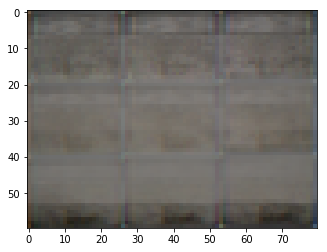

In [10]:
plt.imshow(frame_array[0])

In [8]:
def iterate_minibatches(inputs, targets, batchsize=32, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        idxs = np.arange(len(inputs))
        np.random.shuffle(idxs)

    for idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = idxs[idx:idx + batchsize]
        else:
            excerpt = slice(idx, idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def run_exp(batchsize, num_epochs, data):
    
    video_inputs = tf.placeholder(dtype=tf.float32, shape=(None, 64, 60, 80, 3), name='inputs')
    video_outputs = tf.placeholder(dtype=tf.float32, shape=(None, 64, 60, 80, 3), name='outputs')
    
    targets, predictions, decoded = build_model(
        video_inputs, video_outputs, 
        encoder, lstm_cell, decoder, 
        batchsize
    )

    l2_weight = .02
    l2_vars = [v for v in tf.trainable_variables() if 'bias' not in v.name]
    l2_vars = [v for v in l2_vars if 'lstm' not in v.name]
    l2_term = tf.add_n([tf.nn.l2_loss(v) for v in l2_vars])
    
    loss = tf.reduce_mean(tf.pow(decoded - video_outputs, 2))
    train_step = tf.train.AdamOptimizer().minimize(loss + l2_weight*l2_term)
    
    saver = tf.train.Saver()
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    
    coord = tf.train.Coordinator()
        
    with tf.Session() as sesh:
        sesh.run(init_global)
        sesh.run(init_local)
        threads = tf.train.start_queue_runners(sess=sesh, coord=coord)

        losses = []
        predictions = []
        X = data[:, :-1, :, :, :]
        y = data[:, 1:, :, :, :]
        for epoch in range(num_epochs):
            batch_no = 0
            for X_batch, y_batch in iterate_minibatches(X, y, batchsize=batchsize, shuffle=True):
                _, loss_value = sesh.run(
                    [train_step, loss], 
                    feed_dict={video_inputs: X_batch, video_outputs: y_batch}
                )
                
                losses.append(loss_value / batchsize)
                if epoch % 10 == 0:
                    if batch_no == 0:
                        pred = sesh.run(decoded, feed_dict={video_inputs: X_batch, video_outputs: y_batch})
                        predictions.append(pred)

            print('Epoch {} loss: {:.8f}'.format(epoch, loss_value))
            
        saver.save(sesh, 'prototype-lstm-dummydata')
        
    return losses, predictions

In [ ]:
video_mask = np.ones((1024, 65, 3, 60, 80), dtype=np.uint8)
frame = np.eye(60, dtype=np.uint8)
padded = np.pad(frame, ((0, 0), (0, 20)), 'constant')

video = video_mask * padded
video = video.transpose((0, 1, 3, 4, 2))

losses, predictions = run_exp(16, 31, video.astype(np.float32))

[None, 54, 74, 32] 127872
[None, 54, 74, 32] 127872
Epoch 0 loss: 0.00141136
Epoch 1 loss: 0.00137648
Epoch 2 loss: 0.00136667
Epoch 3 loss: 0.00107762
Epoch 4 loss: 0.00092498
Epoch 5 loss: 0.00074946
Epoch 6 loss: 0.00062873
Epoch 7 loss: 0.00058377
Epoch 8 loss: 0.00052654
Epoch 9 loss: 0.00052334
Epoch 10 loss: 0.00048500
Epoch 11 loss: 0.00045160
Epoch 12 loss: 0.00047589
Epoch 20 loss: 0.00037393
Epoch 21 loss: 0.00041242
Epoch 22 loss: 0.00048877
Epoch 23 loss: 0.00029773
Epoch 24 loss: 0.00036219
Epoch 25 loss: 0.00028578
Epoch 26 loss: 0.00024851
Epoch 27 loss: 0.00038165
Epoch 28 loss: 0.00110055
Epoch 29 loss: 0.02129955
Epoch 30 loss: 0.06080876


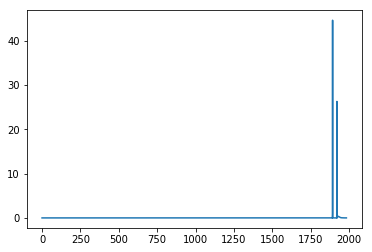

In [11]:
plt.plot(losses)

In [12]:
def render_movie(frame_array, output_file, fps, max_pixel=255):
    n_frames = frame_array.shape[0]
    scaled_array = frame_array * 127.5 + 127.5
    clipped_frames = np.minimum(np.maximum(scaled_array, 0), max_pixel).astype(np.uint8)
    clip = mpe.ImageSequenceClip(list(clipped_frames), fps=fps)
    clip.write_videofile(output_file)
    return clipped_frames

frame_array = render_movie(predictions[1][0], 'test_lstm_pred_dummy.mp4', 5)

[MoviePy] >>>> Building video test_lstm_pred_dummy.mp4
[MoviePy] Writing video test_lstm_pred_dummy.mp4


100%|██████████| 64/64 [00:00<00:00, 1575.88it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_lstm_pred_dummy.mp4 



In [16]:
frame_array[0]

array([[[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ..., 
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]],

       [[127, 127, 127],
        [127, 127, 128],
        [127, 127, 127],
        ..., 
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]],

       [[127, 127, 127],
        [127, 127, 127],
        [128, 128, 128],
        ..., 
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]],

       ..., 
       [[127, 127, 128],
        [127, 127, 127],
        [127, 127, 128],
        ..., 
        [128, 128, 128],
        [128, 128, 128],
        [128, 127, 127]],

       [[127, 127, 128],
        [128, 128, 128],
        [127, 127, 127],
        ..., 
        [128, 128, 128],
        [128, 128, 128],
        [128, 127, 127]],

       [[127, 127, 128],
        [128, 128, 128],
        [128, 128, 128],
        ..., 
        [127, 127, 127],
        [127, 127, 127],
        [127, 127,